In [1]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# function to compute least common multipler
def lcm(numbers):
    return reduce(lambda x, y: (x*y)/gcd(x,y), numbers, 1)

# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = floor(len(x)/N)
    x_ = reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, mean(abs(X)**2,axis=0)


In [3]:
def afsk(bits, fs = 48000, baud=1200, mark_f = 1200, space_f = 2200):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    fs_lcm = lcm((baud, fs))
    
    fc = (mark_f+space_f)/2
    df = (mark_f-space_f)/2
    
    samples_per_bit = fs_lcm/baud
    mark_f = np.empty(0)
    
    N = samples_per_bit*len(bits)
    
    for i in bits:
        mark_f = np.r_[mark_f, np.repeat(1 if i else -1, samples_per_bit)]
        
    t = np.linspace(0,len(bits)*1.0/baud,N-1)
    
    phase = 2*pi*fc*t + 2*pi*df*integrate.cumtrapz(mark_f*(1.0/fs_lcm))
    sig = np.cos(phase)
    
    return sig[::fs_lcm/fs]

def mfsk(bits, fs = 48000, baud=1200, freqs = [900, 1200, 1800, 2100]):
    # the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 48000Hz
    #  Inputs:
    #         bits  - bitarray of bits
    #         fs    - sampling rate
    # Outputs:
    #         sig    -  returns afsk1200 modulated signal
    
    fs_lcm = lcm((baud, fs))
    
    fc = (freqs[1]+freqs[2])/2
    df = (freqz[2]-freqs[1])/2
    
    samples_per_bit = fs_lcm/baud
    mark_f = np.empty(0)
    
    N = samples_per_bit*len(bits)
    
    for i in bits:
        mark_f = np.r_[mark_f, np.repeat(1 if i else -1, samples_per_bit)]
        
    t = np.linspace(0,len(bits)*1.0/baud,N-1)
    
    phase = 2*pi*fc*t + 2*pi*df*integrate.cumtrapz(mark_f*(1.0/fs_lcm))
    sig = np.cos(phase)
    
    return sig[::fs_lcm/fs]

def nc_afsk1200Demod(sig, fs=48000.0, baud=1200, TBW=2.0):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZ (without rectifying it)
    # 
    # sig  - signal
    # baud - The bitrate. Default 1200
    # fs   - sampling rate in Hz
    # TBW  - TBW product of the filters
    #
    # Returns:
    #     NRZ 
    
    # your code here
    N = (fs*TBW*1.0/1200 // 2) * 2 + 1
    h = signal.firwin(N,600.0,nyq=fs/2,window='hanning')

    t = np.arange(0,N*1.0/fs, 1.0/fs)
    
    h_s = np.exp(1j*2*pi*t*1200) * h
    h_m = np.exp(1j*2*pi*t*2200) * h

    space = np.abs(signal.fftconvolve(sig, h_s, mode='same'))
    mark = np.abs(signal.fftconvolve(sig, h_m, mode='same'))

    NRZ = space - mark
    return NRZ

def PLL(NRZa, a = 0.74 , fs = 48000, baud = 1200):
    # 
    # function implements a simple phased lock loop for timing recovery
    #
    # Inputs:
    #          NRZa -   The NRZ signal
    #          a - nudge factor
    #          fs - sampling rate (arbitrary)
    #          baude  - the bit rate
    #
    # Outputs:
    #          idx - array of indexes to sample at
    #
    ctr = int32(-2147483648)
    idx = []
    prev_val = NRZa[0]
    cur_val = NRZa[0]
    for i in range(NRZa.shape[0]):
        # increment counter
        prev_ctr = ctr
        ctr = int32(ctr + 2**32/(fs/baud))
        
        #check overflow
        if np.sign(prev_ctr) == 1 and np.sign(ctr) == -1:
            idx += [i]
        
        #zero-crossing
        prev_val, cur_val = cur_val, NRZa[i]
        if np.sign(cur_val) != np.sign(prev_val):
            ctr = int32(ctr * a)
            
    return idx

/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shane/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


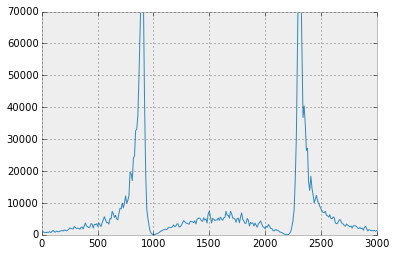

In [7]:
fs = 48e3
baud = 1400
df=10
mark_f, space_f = 800, 2400 #mark and space multiplse
L = 4096

bits=bitarray.bitarray((rand(L)>0.5).tolist())

# Your code here
sig = afsk(bits, fs=fs, baud=baud, mark_f=mark_f, space_f=space_f)

f, P = avgPS(sig, N=int(fs/df), fs=fs)
plt.plot(f,P)
plt.axis([0,3e3,0,70000])
plt.show()

In [ ]:
NRZa = nc_afsk1200Demod(sig, fs, baud)
idx = PLL(NRZa, baud=baud)

bit_dec = bitarray.bitarray((NRZa[idx] > 0).tolist())

num_correct = (~(bits ^ bit_dec)).count()
BER = (L-num_correct*1.0)/L

print BER